# **Рубежный контроль 2: Метод опорных векторов, Случайный лес**

### Козлов Егор ИУ5-62Б

## Содержание
1. Описание датасета. Загрузка данных.
2. Разделение выборки на тестовую и обучающую. Масштабирование данных
3. Метод опорных векторов
4. Случайный лес

## 1. Описание датасета

Возьмем уже известный датасет из [1ой лабораторной](https://github.com/KZLZG/TML/blob/main/Lab1/lab-1.ipynb), мы уже его проанализировали.

#### Импорт библиотек

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#### Загрузка данных
Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные в формате CSV, столбцы разделены табуляцией

In [71]:
data = pd.read_csv('hotel_bookings.csv', sep=",")

In [72]:
# Напомним себе содержание датасета
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [73]:
lab_data = data[['hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'customer_type',  'adults',  'total_of_special_requests']]
lab_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   hotel                      119390 non-null  object
 1   is_canceled                119390 non-null  int64 
 2   lead_time                  119390 non-null  int64 
 3   arrival_date_week_number   119390 non-null  int64 
 4   arrival_date_day_of_month  119390 non-null  int64 
 5   customer_type              119390 non-null  object
 6   adults                     119390 non-null  int64 
 7   total_of_special_requests  119390 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 7.3+ MB


проведем категоризацию hotel

C:\Users\kozlo\AppData\Local\Temp\ipykernel_7080\1407695084.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(lab_data.corr(), dtype=np.bool)


<AxesSubplot:>

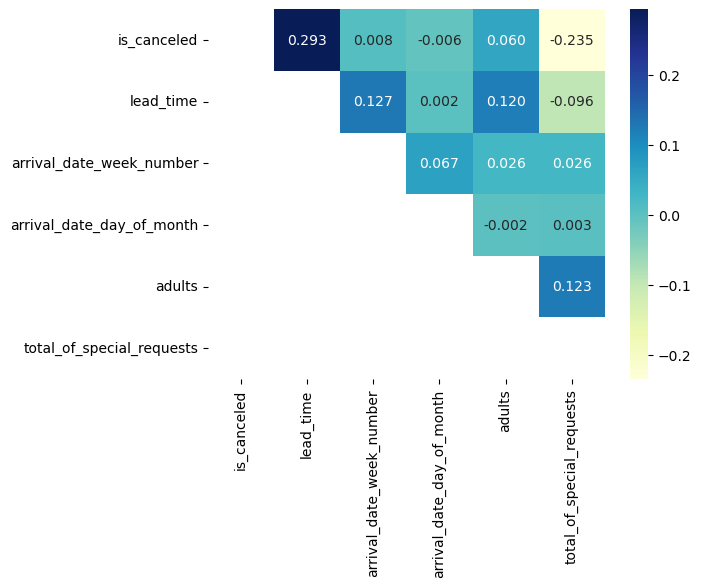

In [74]:
# Треугольный вариант матрицы
mask = np.zeros_like(lab_data.corr(), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(lab_data.corr(), mask=mask, annot=True, fmt='.3f', cmap='YlGnBu')   

In [75]:
print(lab_data['hotel'].unique(),
        lab_data['customer_type'].unique())

['Resort Hotel' 'City Hotel'] ['Transient' 'Contract' 'Transient-Party' 'Group']


In [76]:
le = LabelEncoder()
le2 = LabelEncoder()
hotel_enc_le = le.fit_transform(lab_data['hotel'])
lab_data['hotel'] = hotel_enc_le
cust_enc_le = le2.fit_transform(lab_data['customer_type'])
lab_data['customer_type'] = cust_enc_le
lab_data

C:\Users\kozlo\AppData\Local\Temp\ipykernel_7080\743385284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_data['hotel'] = hotel_enc_le
C:\Users\kozlo\AppData\Local\Temp\ipykernel_7080\743385284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_data['customer_type'] = cust_enc_le


,hotel,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,customer_type,adults,total_of_special_requests
0,1,0,342,27,1,2,2,0
1,1,0,737,27,1,2,2,0
2,1,0,7,27,1,2,1,0
3,1,0,13,27,1,2,1,0
4,1,0,14,27,1,2,2,1
...,...,...,...,...,...,...,...,...
119385,0,0,23,35,30,2,2,0
119386,0,0,102,35,31,2,3,2
119387,0,0,34,35,31,2,2,4
119388,0,0,109,35,31,2,2,0


### Возьмем customer_type как итоговый признак

Можем заметить что признаки отличаются друг от друга по масштабу, поэтому необходимо привести их к единому методом стандартизации, так как это оптимальный способ масштабирования для нашего метода. 

## 2. Разделение выборки на тестовую и обучающую.

Выполним разбиение с поомщью функции sklearn.model_selection.train_test_split, объем тестовой выборки зададим равным 0.2 от общего объема.

In [77]:
# Split the data into features (X) and target (y)
X = lab_data.drop('customer_type', axis=1)
y = lab_data['customer_type']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Обучение случайного леса

In [78]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

## Результаты

In [79]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9140631543680375


In [80]:
y_test.values

array([3, 2, 3, ..., 2, 2, 2])

In [81]:
matrix = confusion_matrix(y_test.values, y_pred)

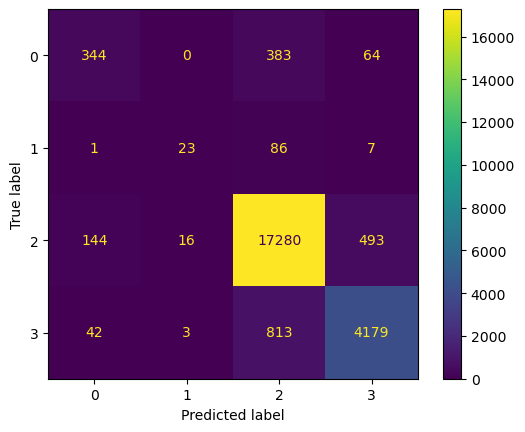

In [84]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix)

cm_display.plot()
plt.show()

In [ ]:
#выведем одно из деревьев решений
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(rf.estimators_[0], feature_names=list(X.columns))
HTML('<pre>' + tree_rules + '</pre>')